In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# utils
from time_vary_norm_utils import cum_pro_and_reactive_time_vary_fn
from time_vary_norm_utils import rho_A_t_fn



# up or down wrt stim given P_A, C_A

In [2]:
from time_vary_norm_utils import (
    int_phi_fn,
    phi_t_fn,
    CDF_E_minus_small_t_NORM_rate_norm_l_time_varying_fn,
    rho_E_minus_small_t_NORM_rate_norm_time_varying_fn
)

def up_or_down_RTs_fit_PA_C_A_given_wrt_t_stim_fn(
        t, bound,
        P_A, C_A,
        ABL, ILD, rate_lambda, T0, theta_E, Z_E, t_E_aff, del_go,
        phi_params, rate_norm_l, 
        is_norm, is_time_vary, K_max):
    
    # t1, t2 - if proactive wins, time range in which EA can hit bound and confirm a choice
    t1 = max(t - t_E_aff, 1e-6)
    t2 = max(t - t_E_aff + del_go, 1e-6)

    # phi(t) and its integral for different times
    if is_time_vary:
        int_phi_t_E_g = int_phi_fn(max(t - t_E_aff + del_go, 1e-6), phi_params.h1, phi_params.a1, phi_params.b1, phi_params.h2, phi_params.a2)

        phi_t_e = phi_t_fn(max(t - t_E_aff, 1e-6), phi_params.h1, phi_params.a1, phi_params.b1, phi_params.h2, phi_params.a2)
        int_phi_t_e = int_phi_fn(max(t - t_E_aff, 1e-6), phi_params.h1, phi_params.a1, phi_params.b1, phi_params.h2, phi_params.a2)

        int_phi_t2 = int_phi_fn(t2, phi_params.h1, phi_params.a1, phi_params.b1, phi_params.h2, phi_params.a2)
        int_phi_t1 = int_phi_fn(t1, phi_params.h1, phi_params.a1, phi_params.b1, phi_params.h2, phi_params.a2)

        if int_phi_t_E_g * int_phi_t_e * int_phi_t2 * int_phi_t1 == 0:
            raise ValueError(
                f'''
                t = {t}, t_E_aff = {t_E_aff}
                t1 = {t1}
                one of them is zero
                int_phi_t_E_g = {int_phi_t_E_g}
                int_phi_t_e = {int_phi_t_e}
                int_phi_t2 = {int_phi_t2}
                int_phi_t1 = {int_phi_t1}

                params  = {phi_params.h1, phi_params.a1, phi_params.b1, phi_params.h2, phi_params.a2}
                '''
                    
                )
    else:
        int_phi_t_E_g = np.nan
        
        phi_t_e = np.nan
        int_phi_t_e = np.nan

        int_phi_t2 = np.nan
        int_phi_t1 = np.nan

    # PA wins and random choice due to EA survival
    P_EA_hits_either_bound = CDF_E_minus_small_t_NORM_rate_norm_l_time_varying_fn(
                                t - t_E_aff + del_go, 1, 
                                ABL, ILD, rate_lambda, T0, theta_E, Z_E, int_phi_t_E_g, rate_norm_l, 
                                is_norm, is_time_vary, K_max)  \
                                + \
                                CDF_E_minus_small_t_NORM_rate_norm_l_time_varying_fn(
                                t - t_E_aff + del_go, -1, 
                                ABL, ILD, rate_lambda, T0, theta_E, Z_E, int_phi_t_E_g, rate_norm_l,
                                is_norm, is_time_vary, K_max)
    
    P_EA_survives = 1 - P_EA_hits_either_bound
    random_readout_if_EA_survives = 0.5 * P_EA_survives
    
    # PA wins and EA hits later
    P_E_plus_cum = CDF_E_minus_small_t_NORM_rate_norm_l_time_varying_fn(
                            t2, bound, 
                            ABL, ILD, rate_lambda, T0, theta_E, Z_E, int_phi_t2, rate_norm_l, 
                            is_norm, is_time_vary, K_max)  \
                            - \
                            CDF_E_minus_small_t_NORM_rate_norm_l_time_varying_fn(
                            t1, bound, 
                            ABL, ILD, rate_lambda, T0, theta_E, Z_E, int_phi_t1, rate_norm_l,
                            is_norm, is_time_vary, K_max)
    

    # EA wins
    P_E_plus = rho_E_minus_small_t_NORM_rate_norm_time_varying_fn(
        t - t_E_aff, bound, ABL, ILD, rate_lambda, T0, theta_E, Z_E, phi_t_e, int_phi_t_e, 
        rate_norm_l, is_norm, is_time_vary, K_max)
    

    

    return (P_A*(random_readout_if_EA_survives + P_E_plus_cum) + P_E_plus*(1-C_A))


# sim params

In [3]:
V_A = 1.6
theta_A = 2.5
t_A_aff = -0.22

rate_lambda = 2.2
T_0 = 100 * 1e-3
theta_E = 3

t_E_aff = 0.068
del_go = 0.13

Z_E = 0.15

rate_norm_l = 0.95

from types import SimpleNamespace

bump_offset = 0
bump_width = 0.240
dip_width = 0.038
dip_height = 0.327

bump_height = 0.5

phi_params = {
    'h1': bump_width,
    'a1': bump_height,
    'h2': dip_width,
    'a2': dip_height,
    'b1': bump_offset
}

phi_params_obj = SimpleNamespace(**phi_params)

# read sim df

In [4]:
with open('sim_results_rate_norm_l_0.95.pkl', 'rb') as f:
    sim_results = pickle.load(f)

sim_results_df = pd.DataFrame(sim_results)
sim_results_df_1 = sim_results_df.copy()
if rate_norm_l == 0:
    is_norm = False
else:
    is_norm = True

print(f'is_norm: {is_norm}')
is_time_vary = True

is_norm: True


# Test stim

In [5]:
# test stim
ABL = 20
ILD = 1

# read data

In [7]:
# repeat_trial, T16, S7
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# theory RTD

In [ ]:
t_pts = np.arange(-1, 2, 0.001)
N_theory = 1000
t_stim_samples = df['intended_fix'].sample(N_theory, replace=True).values
K_max = 10


P_A_samples = np.zeros((N_theory, len(t_pts)))
trunc_fac_samples = np.zeros((N_theory))

for idx, t_stim in enumerate(t_stim_samples):
    P_A_samples[idx, :] = [rho_A_t_fn(t + t_stim - t_A_aff, V_A, theta_A) for t in t_pts]

    trunc_fac_samples[idx] = cum_pro_and_reactive_time_vary_fn(
                                t_stim + 1,
                                V_A, theta_A, t_A_aff,
                                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                                phi_params_obj, rate_norm_l, 
                                is_norm, is_time_vary, K_max) \
                                - \
                                cum_pro_and_reactive_time_vary_fn(
                                t_stim,
                                V_A, theta_A, t_A_aff,
                                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                                phi_params_obj, rate_norm_l, 
                                is_norm, is_time_vary, K_max) + 1e-10


from scipy.integrate import cumulative_trapezoid as cumtrapz

P_A_mean = np.mean(P_A_samples, axis=0)
C_A_mean = cumtrapz(P_A_mean, t_pts, initial=0)

up_mean = np.array([up_or_down_RTs_fit_PA_C_A_given_wrt_t_stim_fn(
        t, 1,
        P_A_mean[i], C_A_mean[i],
        ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
        phi_params_obj, rate_norm_l, 
        is_norm, is_time_vary, K_max) for i, t in enumerate(t_pts)])
down_mean = np.array([up_or_down_RTs_fit_PA_C_A_given_wrt_t_stim_fn(
        t, -1,
        P_A_mean[i], C_A_mean[i],
        ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
        phi_params_obj, rate_norm_l, 
        is_norm, is_time_vary, K_max) for i, t in enumerate(t_pts)])


#### NO TRUNCATION #####
# trunc_factor = np.mean(trunc_fac_samples)

### TRUNC ######
trunc_factor = 1
up_theory_mean_norm = up_mean / trunc_factor
down_theory_mean_norm = down_mean / trunc_factor


# theory and sim

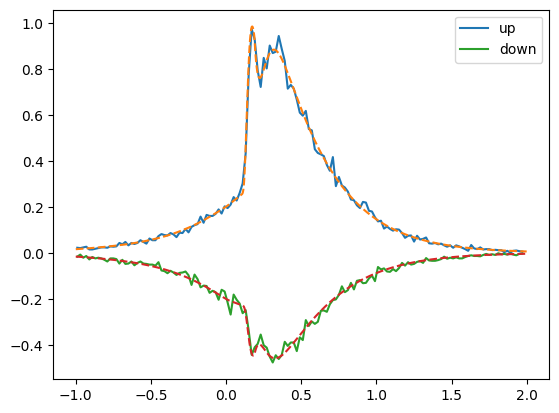

In [10]:
### test - single case ####
sim_results_df_og = pd.DataFrame(sim_results)
sim_results_df = sim_results_df_og[(sim_results_df_og['ABL'] == ABL) & (sim_results_df_og['ILD'] == ILD)]

### NO TRUNC
sim_results_df_1 = sim_results_df.copy()


######### NO TRUNCATION #################
# sim_results_df_1 = sim_results_df[
#     (sim_results_df['rt'] - sim_results_df['t_stim'] > 0) &
#     (sim_results_df['rt'] - sim_results_df['t_stim'] < 1)
# ]

sim_abl_ild = sim_results_df_1[(sim_results_df_1['ABL'] == ABL) & (sim_results_df_1['ILD'] == ILD)]
sim_up = sim_abl_ild[sim_abl_ild['choice'] == 1]
sim_down = sim_abl_ild[sim_abl_ild['choice'] == -1]

up_rt = sim_up['rt'] - sim_up['t_stim']
down_rt = sim_down['rt'] - sim_down['t_stim']

bw = 0.02
bins = np.arange(-1, 2, bw)
up_hist, _ = np.histogram(up_rt, bins=bins, density=True)
down_hist, _ = np.histogram(down_rt, bins=bins, density=True)

frac_up = len(sim_up) / len(sim_abl_ild)
frac_down = len(sim_down) / len(sim_abl_ild)

bin_centers = bins[:-1] + 0.5*bw
plt.plot(bin_centers, up_hist * frac_up, label='up')
plt.plot(t_pts, up_theory_mean_norm, ls='--')

plt.plot(bin_centers, -down_hist * frac_down, label='down')
plt.plot(t_pts, -down_theory_mean_norm, ls='--')
plt.legend()


# 0 and 1

In [ ]:
t_pts = np.arange(-1, 2, 0.001)
N_theory = 1000
t_stim_samples = df['intended_fix'].sample(N_theory, replace=True).values
K_max = 10


P_A_samples = np.zeros((N_theory, len(t_pts)))
trunc_fac_samples = np.zeros((N_theory))

for idx, t_stim in enumerate(t_stim_samples):
    P_A_samples[idx, :] = [rho_A_t_fn(t + t_stim - t_A_aff, V_A, theta_A) for t in t_pts]

    trunc_fac_samples[idx] = cum_pro_and_reactive_time_vary_fn(
                                t_stim + 1,
                                V_A, theta_A, t_A_aff,
                                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                                phi_params_obj, rate_norm_l, 
                                is_norm, is_time_vary, K_max) \
                                - \
                                cum_pro_and_reactive_time_vary_fn(
                                t_stim,
                                V_A, theta_A, t_A_aff,
                                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                                phi_params_obj, rate_norm_l, 
                                is_norm, is_time_vary, K_max) + 1e-10


from scipy.integrate import cumulative_trapezoid as cumtrapz

P_A_mean = np.mean(P_A_samples, axis=0)
C_A_mean = cumtrapz(P_A_mean, t_pts, initial=0)

up_mean = np.array([up_or_down_RTs_fit_PA_C_A_given_wrt_t_stim_fn(
        t, 1,
        P_A_mean[i], C_A_mean[i],
        ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
        phi_params_obj, rate_norm_l, 
        is_norm, is_time_vary, K_max) for i, t in enumerate(t_pts)])
down_mean = np.array([up_or_down_RTs_fit_PA_C_A_given_wrt_t_stim_fn(
        t, -1,
        P_A_mean[i], C_A_mean[i],
        ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
        phi_params_obj, rate_norm_l, 
        is_norm, is_time_vary, K_max) for i, t in enumerate(t_pts)])



trunc_factor = np.mean(trunc_fac_samples)



In [33]:
mask_0_1      = (t_pts >= 0) & (t_pts <= 1)   # boolean index
t_pts_0_1     = t_pts[mask_0_1]               # time vector you already made

up_mean_0_1   = up_mean[mask_0_1]
down_mean_0_1 = down_mean[mask_0_1]


In [34]:
up_theory_mean_norm = up_mean_0_1 / trunc_factor
down_theory_mean_norm = down_mean_0_1 / trunc_factor

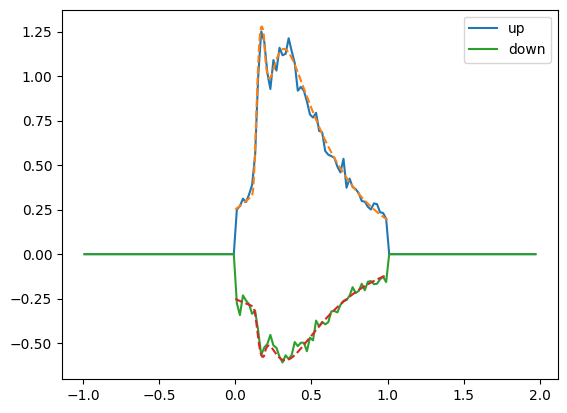

In [36]:
### test - single case ####
sim_results_df_og = pd.DataFrame(sim_results)
sim_results_df = sim_results_df_og[(sim_results_df_og['ABL'] == ABL) & (sim_results_df_og['ILD'] == ILD)]

sim_results_df_1 = sim_results_df[
    (sim_results_df['rt'] - sim_results_df['t_stim'] > 0) &
    (sim_results_df['rt'] - sim_results_df['t_stim'] < 1)
]

sim_abl_ild = sim_results_df_1[(sim_results_df_1['ABL'] == ABL) & (sim_results_df_1['ILD'] == ILD)]
sim_up = sim_abl_ild[sim_abl_ild['choice'] == 1]
sim_down = sim_abl_ild[sim_abl_ild['choice'] == -1]

up_rt = sim_up['rt'] - sim_up['t_stim']
down_rt = sim_down['rt'] - sim_down['t_stim']

bw = 0.02
bins = np.arange(-1, 2, bw)
up_hist, _ = np.histogram(up_rt, bins=bins, density=True)
down_hist, _ = np.histogram(down_rt, bins=bins, density=True)

frac_up = len(sim_up) / len(sim_abl_ild)
frac_down = len(sim_down) / len(sim_abl_ild)

bin_centers = bins[:-1] + 0.5*bw
plt.plot(bin_centers, up_hist * frac_up, label='up')
plt.plot(t_pts_0_1, up_theory_mean_norm, ls='--')

plt.plot(bin_centers, -down_hist * frac_down, label='down')
plt.plot(t_pts_0_1, -down_theory_mean_norm, ls='--')
plt.legend()


# tacho

In [45]:
def plot_tacho(df, bins):
    df['RT_bin'] = pd.cut(df['rt'] - df['t_stim'], bins=bins, include_lowest=True)
    grouped_by_rt_bin = df.groupby('RT_bin', observed=False)['correct'].agg(['mean', 'count'])
    grouped_by_rt_bin['bin_mid'] = grouped_by_rt_bin.index.map(lambda x: x.mid)
    return grouped_by_rt_bin['bin_mid'], grouped_by_rt_bin['mean']

In [49]:
bins = np.arange(0, 1, 0.02)
sim_abl_ild.loc[:, 'correct'] = (sim_abl_ild['ILD'] * sim_abl_ild['choice'] > 0).astype(int)

(0.0, 1.0)

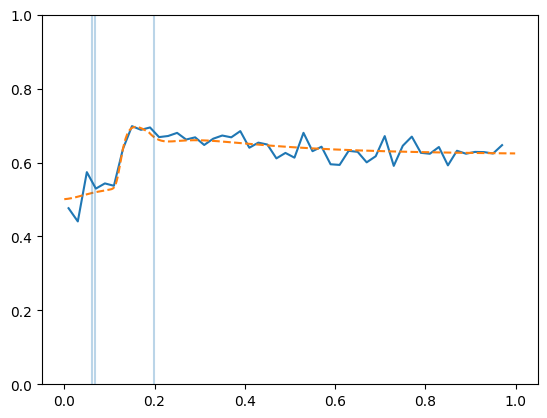

In [62]:
data_tacho_x, data_tacho_y = plot_tacho(sim_abl_ild, bins)
plt.plot(data_tacho_x, data_tacho_y, label='data')

# theory_tacho = up_theory_mean_norm / (up_theory_mean_norm + down_theory_mean_norm + 1e-10)
theory_tacho = np.zeros_like(t_pts_0_1)
for idx, t in enumerate(t_pts_0_1):
    theory_tacho[idx] = up_theory_mean_norm[idx] / (up_theory_mean_norm[idx] + down_theory_mean_norm[idx] + 1e-20)
    # theory_tacho[idx] = up_mean_0_1[idx] / (up_mean_0_1[idx] + down_mean_0_1[idx] + 1e-20)

plt.plot(t_pts_0_1, theory_tacho, ls='--')
plt.axvline(t_E_aff, alpha=0.3)
plt.axvline(del_go - t_E_aff, alpha=0.3)
plt.axvline(del_go + t_E_aff, alpha=0.3)
plt.ylim(0,1)

In [54]:
del_go

0.13